In [54]:
import pandas as pd
from helpers import *
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from aif360.sklearn.inprocessing import AdversarialDebiasing, ExponentiatedGradientReduction
from tensorflow.python.framework.ops import disable_eager_execution

In [55]:
## Load the pre-processed dataset.
df=pd.read_csv("./data/standard_df.csv")

## Load the xgboost dataset.
xgboost_df=pd.read_csv("./data/xgboost_df.csv")

## Create a list with the protected attributes that are going to be used. 
prot_attr=['Previous_qualification', 'Debtor', 'Tuition_fees_up_to_date']

In [56]:
## Split the dataset and standardize it. 

X_train, X_test, y_train, y_test, indices_train, indices_test=standardized_dataset_output(
                                                                                            df,
                                                                                            prot_attr,
                                                                                            'Target'
                                                                                        )

In [57]:
## Create two lists of metrics: one for the evaluation metrics and one for the fairness metrics.
eval_metrics=['Balanced Accuracy', 'f1-score', 'ROC-AUC']
fairness_metrics=['Statistical Parity Difference','Disparate Impact Ratio','Equal Opportunity Difference','Average Odds Difference']

### Adversarial Debiasing 

In [58]:
disable_eager_execution()
model=AdversarialDebiasing(prot_attr[1:], scope_name="adversary", debias=True, random_state=0)
params={"adversary_loss_weight": [0.1, 0.5, 0.7],
            "num_epochs": [25, 50, 100],
            "batch_size": [32, 64, 128],
            "classifier_num_hidden_units": [100, 200]}
scorer=make_scorer(scoring_func, scoring="average_odds", greater_is_better=False, pref_attr=prot_attr[1])
grid=GridSearchCV(model, params, scoring=scorer, cv=5).fit(X_train, y_train)

In [59]:
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

In [60]:
adv_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

adv_df.to_csv('./data/adv_df.csv')

In [61]:
adv_df

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Previous_qualification,0.8711,0.8982,0.9354,0.4981,5.4833,0.4008,0.2804
1,Debtor,0.8711,0.8982,0.9354,0.3302,2.0444,0.0556,0.0053
2,Tuition_fees_up_to_date,0.8711,0.8982,0.9354,-0.5310,0.2143,-0.0668,-0.0646


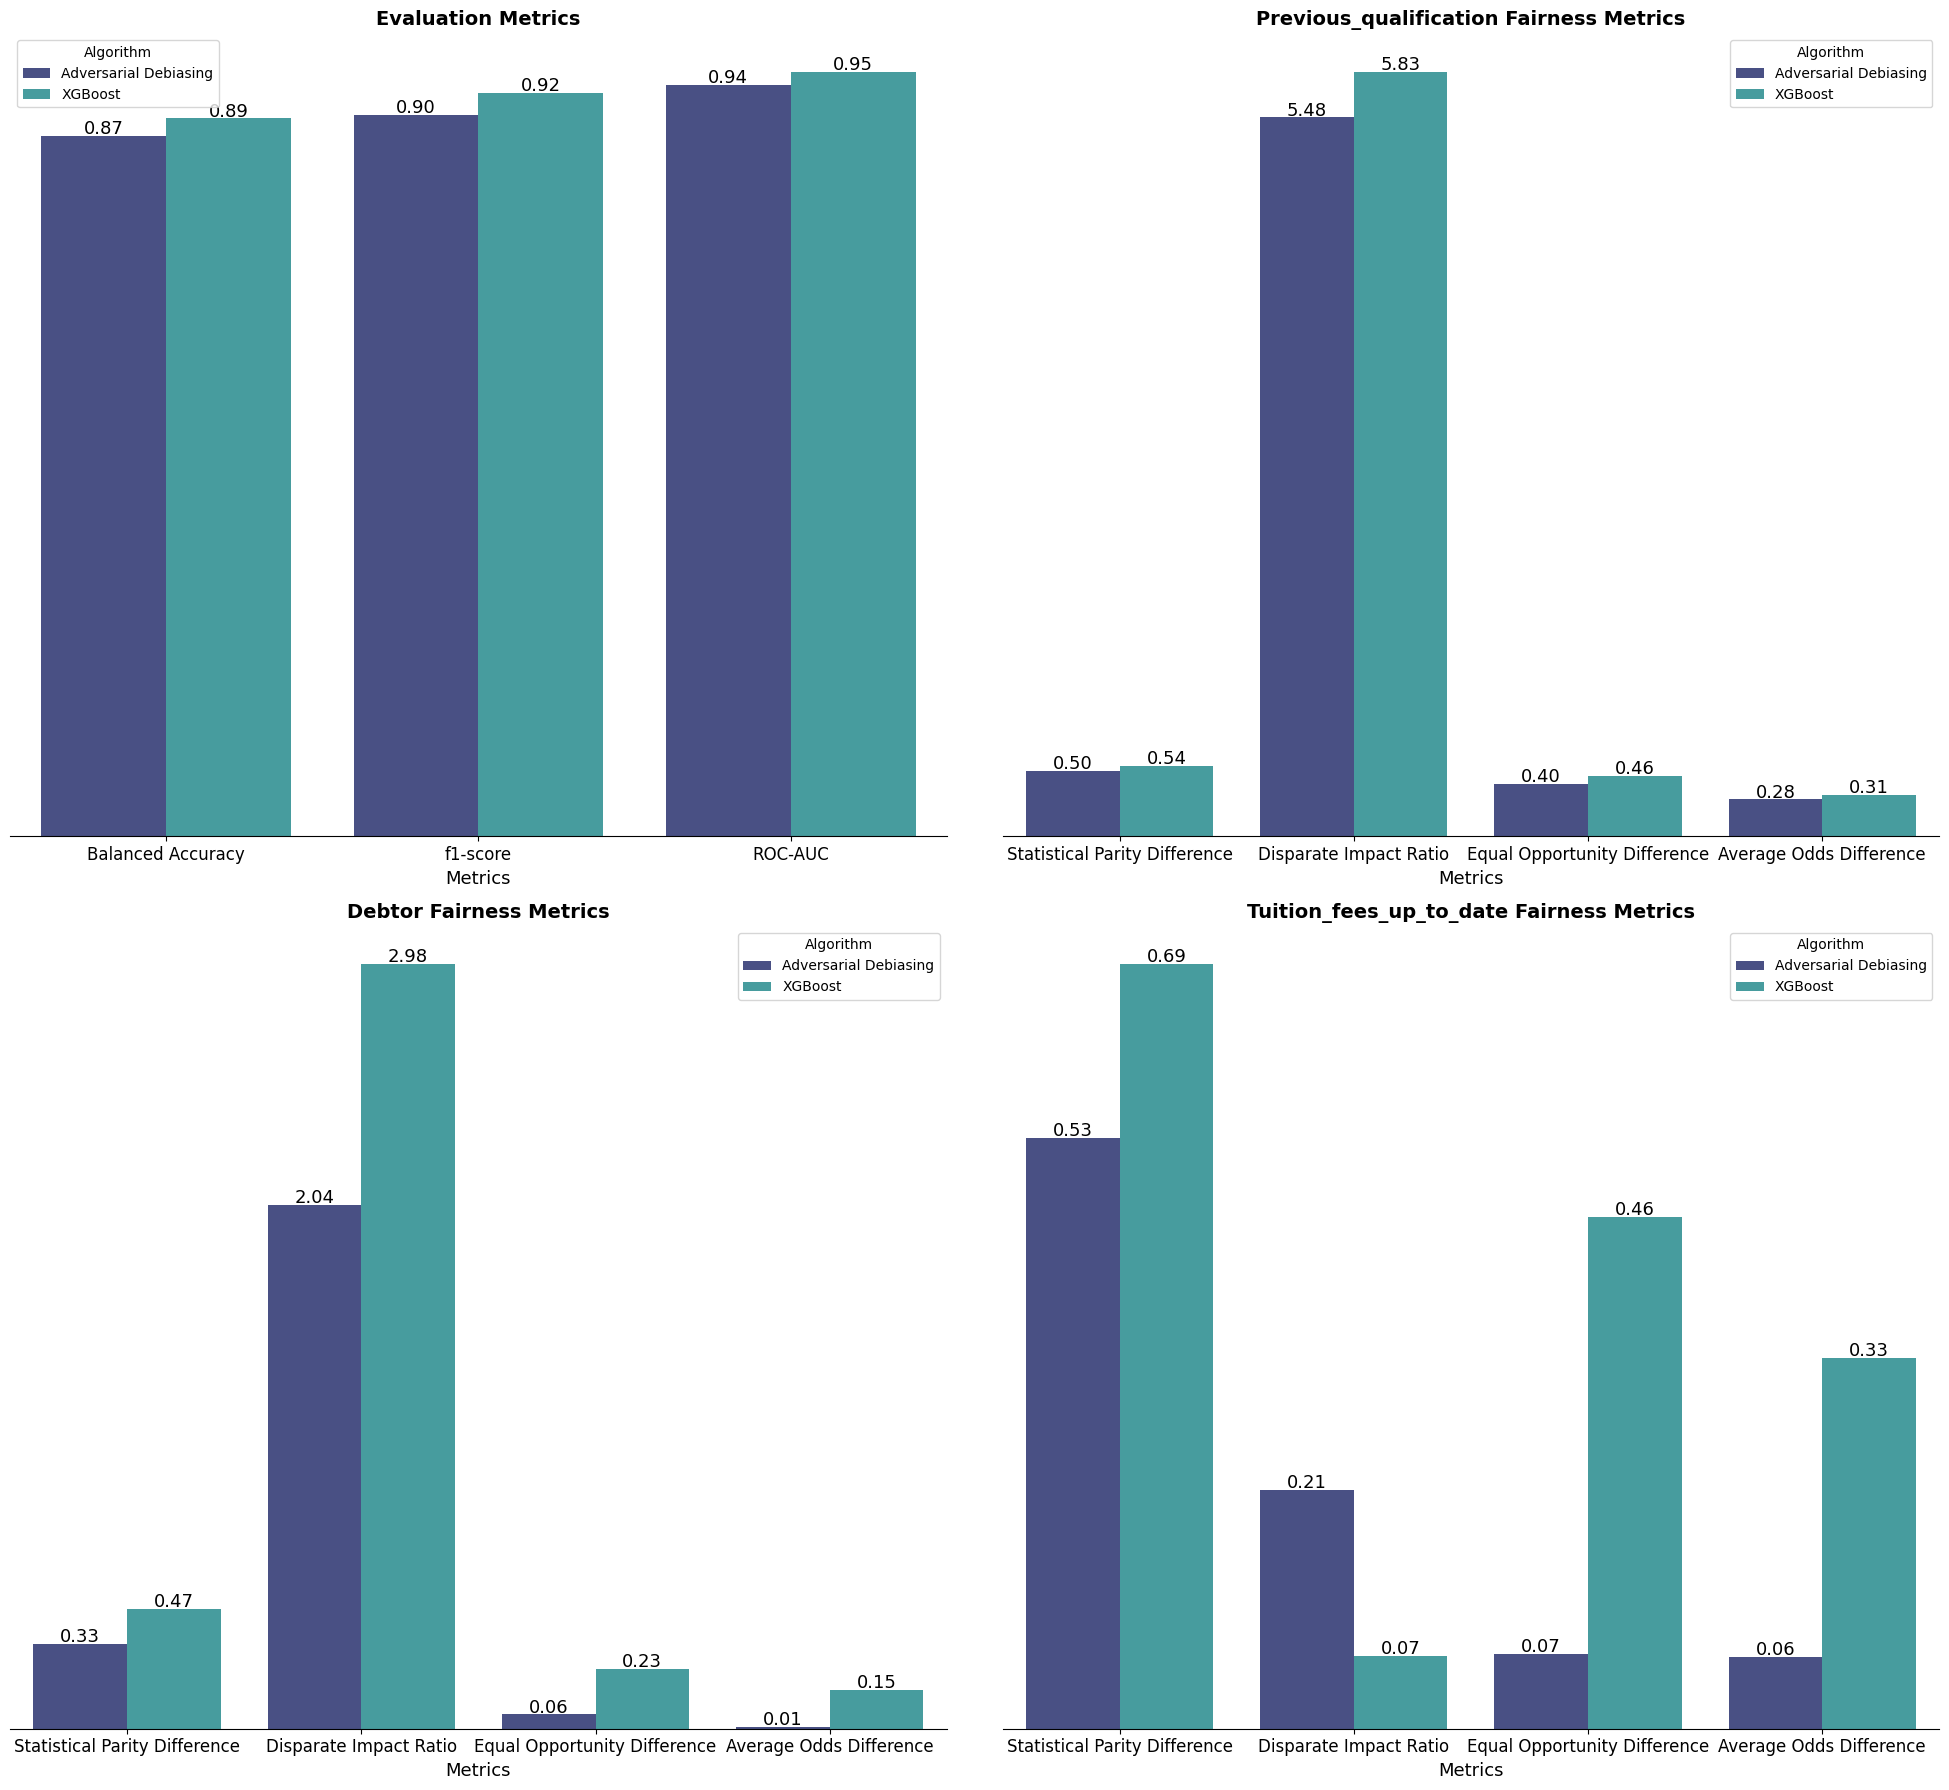

In [62]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(adv_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['Adversarial Debiasing'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(adv_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['Adversarial Debiasing'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


titles =[ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms=['Reject Option based Classification','XGBoost']
plot_2x2_metrics(metrics_list, titles, algorithms)

### Exponentiated Greadient Reduction

In [63]:
np.random.seed(0)
model=ExponentiatedGradientReduction(prot_attr, estimator=XGBClassifier(), constraints="EqualizedOdds")
params={"eta0": [0.01, 0.1, 2.0], "eps": [0.01, 0.05, 0.1]}
scorer=make_scorer(scoring_func, scoring="EqualizedOdds", greater_is_better=False, pref_attr=prot_attr[1])

In [64]:
grid=GridSearchCV(model, params, scoring=scorer, cv=5, n_jobs=4).fit(X_train, y_train)
y_pred=grid.predict(X_test)
y_proba=grid.predict_proba(X_test)[:,1]

In [65]:
exp_df=create_metrics_dataset(y_test, y_pred, y_proba, prot_attr)

exp_df.to_csv('./data/exp_df.csv')

In [66]:
exp_df

,Attribute,Balanced Accuracy,f1-score,ROC-AUC,Statistical Parity Difference,Disparate Impact Ratio,Equal Opportunity Difference,Average Odds Difference
0,Previous_qualification,0.8858,0.9169,0.8858,0.4157,2.8708,0.4420,0.2343
1,Debtor,0.8858,0.9169,0.8858,0.3134,1.8698,-0.0218,-0.0439
2,Tuition_fees_up_to_date,0.8858,0.9169,0.8858,-0.5172,0.2647,0.0599,0.0168


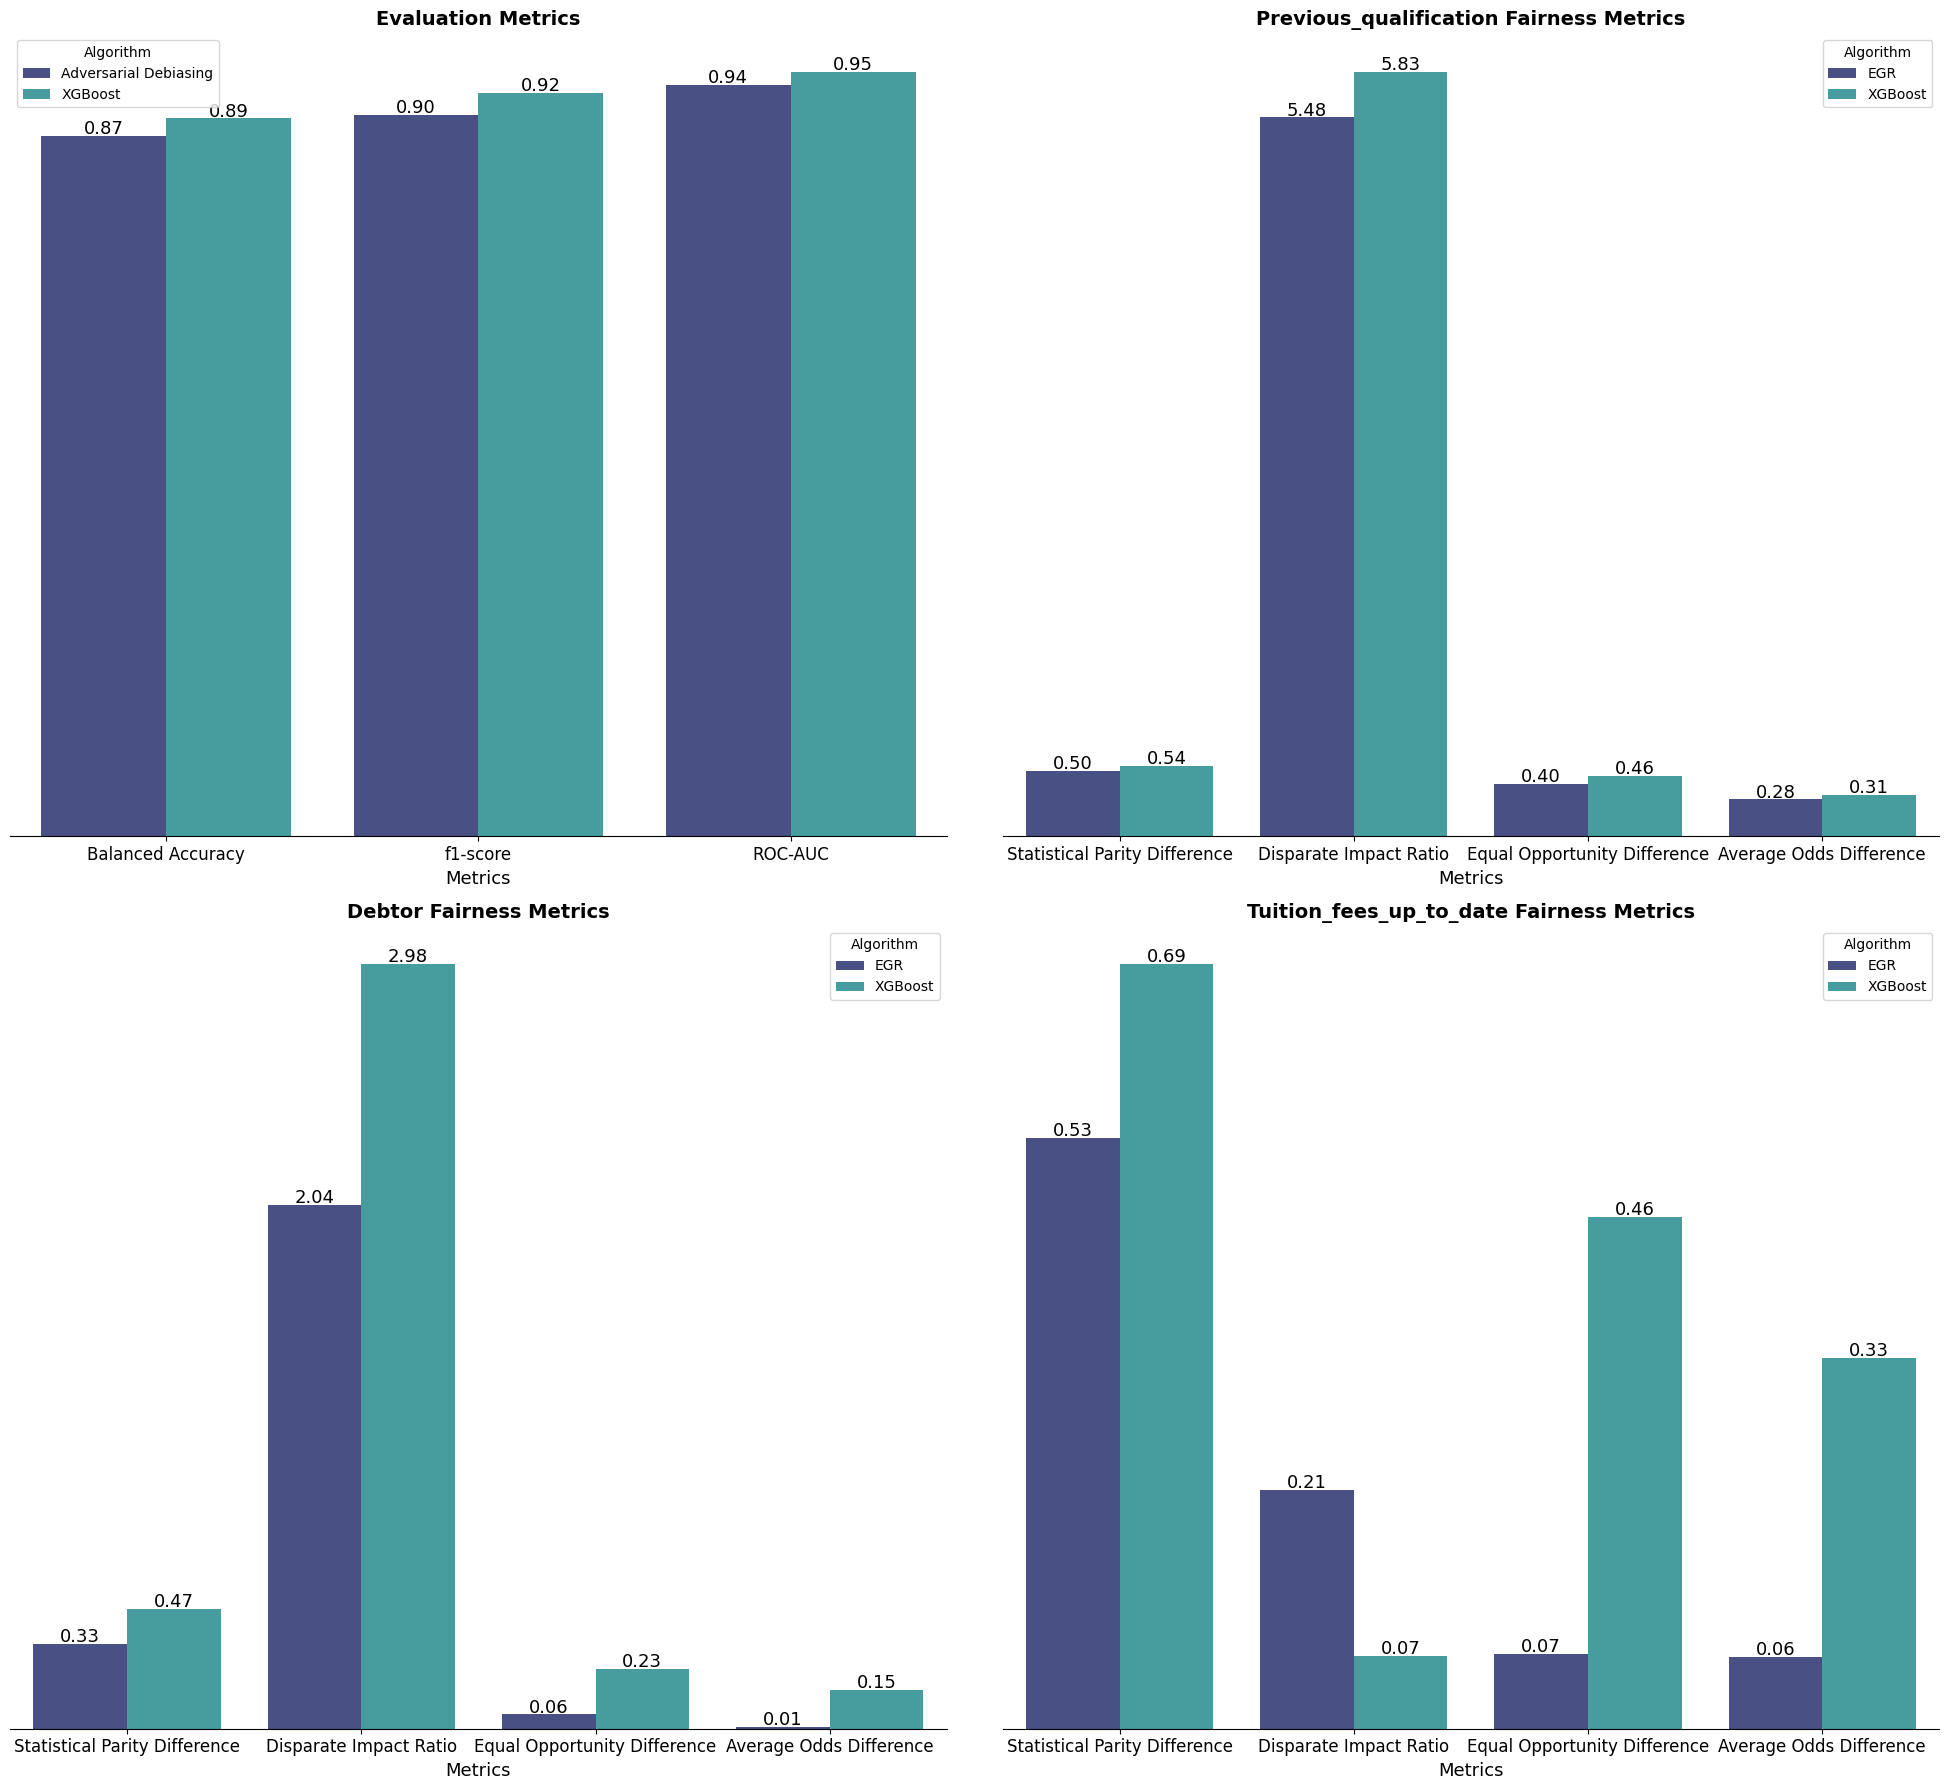

In [68]:
metrics_df = pd.DataFrame({
    'Metric': eval_metrics + eval_metrics,
    'Value': list(adv_df[eval_metrics].iloc[0, :]) + list(xgboost_df[eval_metrics].iloc[0, :]),
    'Algorithm': ['Adversarial Debiasing'] * 3 + ['XGBoost'] * 3
})
metrics_list=[metrics_df]

for i in range(len(prot_attr)):
    metrics_df = pd.DataFrame({
    'Metric': fairness_metrics + fairness_metrics,
    'Value': list(adv_df[fairness_metrics].iloc[i,:]) + list(xgboost_df[xgboost_df["Attribute"]==prot_attr[i]][fairness_metrics].values[0]),
    'Algorithm': ['EGR'] * 4 + ['XGBoost'] * 4
    })
    metrics_df['Value'] = metrics_df['Value'].abs()
    metrics_list.append(metrics_df)


titles =[ "Evaluation Metrics", "Previous_qualification Fairness Metrics", "Debtor Fairness Metrics", "Tuition_fees_up_to_date Fairness Metrics"]
algorithms=['Exponentiated Gradient Reduction','XGBoost']
plot_2x2_metrics(metrics_list, titles, algorithms)